**Note:** *Change to GPU runtime for faster execution*

# First, mount the drive to get access to dataset

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the dataset from drive

In [2]:
import os
import pandas as pd

# Specify the path to dataset and the file name
DATASET_DIR = os.path.join(os.getcwd(), r'drive/MyDrive/NLP Final Project/datasets/sentiment140_kaggle')
FILE = os.path.join(DATASET_DIR, r'Sentiment140.annotated.resampled.100000.csv')

# Open the csv file as a pandas DataFrame with specified columns
tweets_df = pd.read_csv(FILE, sep=',', encoding='utf-8')
tweets_df

,target,tweet,label
0,0,@mimsay We'll miss you. Congrats lil lady.,negative
1,0,Feeling sorry for myself today cos of my drunk...,negative
2,0,My computer won't let me online. On laptop n...,negative
3,0,New Post and lots of sulking http://tinyurl...,negative
4,0,@purplepleather AWW,negative
...,...,...,...
999995,4,@babygirlparis Ten bucks says I know where you...,joy
999996,4,is at the gym then off to cocoa beach for Sund...,joy
999997,4,@joek949 Morning you! Might go to the beach...,joy
999998,0,"maybe going to the beach after work, got 17kno...",joy


# Cleaning the raw tweets

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

> Remove the word 'not' from stopwords as it specifies a negative emotion

In [4]:
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

def clean(tweet):

    # Remove @usermentions (for a tweet)
    tweet = re.sub('@[^\s]+',' ',tweet)

    # Remove urls (for a tweet)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    # Replace #word with word (for a tweet)
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # Remove all remaining punctuations
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)

    # Convert tweet to lowercase
    tweet = tweet.lower()
    
    # Remove stop words
    tweet = tweet.split()
    tweet = ' '.join([word for word in tweet if not word in set(all_stopwords)])
    
    return tweet

> Apply to the `clean` function to DataFrame

In [5]:
%%time
tweets_df['cleaned_tweet'] = tweets_df['tweet'].apply(clean)

CPU times: user 45.7 s, sys: 101 ms, total: 45.8 s
Wall time: 45.8 s


In [6]:
tweets_df

,target,tweet,label,cleaned_tweet
0,0,@mimsay We'll miss you. Congrats lil lady.,negative,miss congrats lil lady
1,0,Feeling sorry for myself today cos of my drunk...,negative,feeling sorry today cos drunken antics last ni...
2,0,My computer won't let me online. On laptop n...,negative,computer let online laptop not upload pics any...
3,0,New Post and lots of sulking http://tinyurl...,negative,new post lots sulking
4,0,@purplepleather AWW,negative,aww
...,...,...,...,...
999995,4,@babygirlparis Ten bucks says I know where you...,joy,ten bucks says know going think let know bould...
999996,4,is at the gym then off to cocoa beach for Sund...,joy,gym cocoa beach sunday funday
999997,4,@joek949 Morning you! Might go to the beach...,joy,morning might go beach think
999998,0,"maybe going to the beach after work, got 17kno...",joy,maybe going beach work got knots wind today ho...


# Split the data into train set and test set

In [7]:
from sklearn.model_selection import train_test_split

X = tweets_df.cleaned_tweet.values
y = tweets_df.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Specify the hyper parameters

In [8]:
MAX_VOCAB_SIZE = 20000
MAX_LEN = 1000

EMBEDDING_DIM = int(round(MAX_VOCAB_SIZE ** 0.25))

# Prepare the data for training

> **Tokenize**

In [9]:
%%time
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

CPU times: user 10.5 s, sys: 186 ms, total: 10.6 s
Wall time: 10.7 s


> **Convert to sequences**

In [10]:
%%time
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

CPU times: user 10.5 s, sys: 95 ms, total: 10.6 s
Wall time: 10.6 s


> **Pad the sequences to convert all inputs to same shape**

In [11]:
%%time
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

CPU times: user 3.9 s, sys: 677 ms, total: 4.58 s
Wall time: 4.58 s


> **Label encode the 10 classes and convert them to one-hot encodings**

In [12]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical


encoder = LabelEncoder()
transformed_labels = encoder.fit_transform(tweets_df.label.values)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# CNN model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, MaxPooling1D

> **Specify model parameters**

In [14]:
FILTERS = 32
KERNEL_SIZE = 3

EPOCHS = 5
BATCH_SIZE = 32

> **Create a model**

In [15]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    Conv1D(FILTERS, KERNEL_SIZE, padding='valid', activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 12)          240000    
_________________________________________________________________
conv1d (Conv1D)              (None, 998, 32)           1184      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 499, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 15968)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               8176128   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

> **Compile the model**

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

> **Implement callback to stop training on 95% accuracy**

In [17]:
# Implement callback function to stop training
# when accuracy reaches ACCURACY_THRESHOLD
ACCURACY_THRESHOLD = 0.95

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') is not None and logs.get('accuracy') >= ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

> **Fit the model**

In [18]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[callbacks])

Epoch 1/5
25000/25000 [==============================] - 240s 9ms/step - loss: 0.6529 - accuracy: 0.7761
Epoch 2/5
25000/25000 [==============================] - 237s 9ms/step - loss: 0.2614 - accuracy: 0.9145
Epoch 3/5
25000/25000 [==============================] - 237s 9ms/step - loss: 0.2272 - accuracy: 0.9259
Epoch 4/5
25000/25000 [==============================] - 236s 9ms/step - loss: 0.2073 - accuracy: 0.9325
Epoch 5/5
25000/25000 [==============================] - 237s 9ms/step - loss: 0.1919 - accuracy: 0.9375


> **Predict on test data**

In [19]:
y_pred = model.predict(X_test)

# Classification report

In [30]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

print("Report:\n")
average = 'macro'

print(f"Accuracy score  : {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))}")
print(f"Precision score : {precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average=average)}")
print(f"Recall score    : {recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average=average)}")
print(f"F1 score        : {f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average=average)}")

Report:

Accuracy score  : 0.921145
Precision score : 0.9194803082824674
Recall score    : 0.9211733634571366
F1 score        : 0.92003672444197


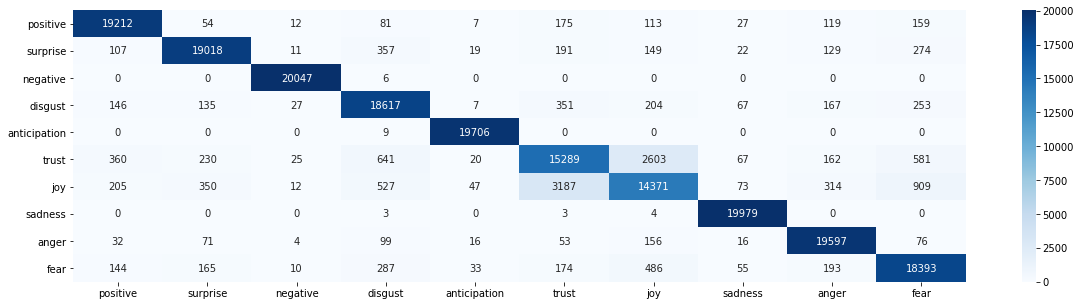

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(20, 5))

sns.heatmap(cm, fmt="d", annot=True, cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))